## Load Data

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.model_selection import train_test_split
from gensim.models import KeyedVectors

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/sentiment140/training.1600000.processed.noemoticon.csv
/kaggle/input/preprocessed-tweets/data.feather


In [4]:
import nltk
from nltk.tokenize import word_tokenize
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
%time data = pd.read_feather("/kaggle/input/preprocessed-tweets/data.feather")

In [6]:
data.head()

,text,label
0,http twitpic com zl awww bummer shoulda got da...,negative
1,upset update facebook texting might cry result...,negative
2,dived many time ball managed save rest go bound,negative
3,whole body feel itchy like fire,negative
4,behaving mad see,negative


In [7]:
train, test = train_test_split(data, test_size=0.2, random_state=42, stratify=data['label'])
train, val = train_test_split(train, test_size=0.1, random_state=42, stratify=train['label'])

## Words Embeddings

In [ ]:
import gensim.downloader as api
from gensim.models import Word2Vec, KeyedVectors

# Download and load a small pretrained Word2Vec model
# model_emb = api.load("fasttext-wiki-news-subwords-300")
# model_emb.save("fasttext-wiki-news-subwords-300.model")

In [9]:
#model_emb.save("word2vec.bin")
# Load the model
model_emb = KeyedVectors.load("/kaggle/working/fasttext-wiki-news-subwords-300.model")

In [10]:
def sentence_to_vec(sentence, model, vector_size=300):
    words = sentence.lower().split()
    word_vecs = []

    for word in words:
        if word in model:
            word_vecs.append(model[word])
    
    if len(word_vecs) == 0:
        return np.zeros(vector_size)  
    
    word_vecs = np.array(word_vecs)
    return np.mean(word_vecs, axis=0)

In [11]:
# Convert text to vectors
X_train_vec = np.array([sentence_to_vec(text, model_emb) for text in train['text']])
X_val_vec = np.array([sentence_to_vec(text, model_emb) for text in val['text']])
X_test_vec = np.array([sentence_to_vec(text, model_emb) for text in test['text']])

# Labels
y_train = train['label'].values
y_val = val['label'].values
y_test = test['label'].values

## Training

### Model 1 : scales (2,3,4)

In [21]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, Concatenate, Dense, Dropout, Embedding, Reshape, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder

# Check for GPU availability
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("GPU memory growth set to True")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)
    print(f"Using GPU: {gpus[0].name}")
else:
    print("No GPU found. Using CPU instead.")

# Set TensorFlow to use GPU if available
tf.config.set_visible_devices(gpus, 'GPU')

le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_val_encoded = le.transform(y_val)
y_test_encoded = le.transform(y_test)

y_train_cat = to_categorical(y_train_encoded)
y_val_cat = to_categorical(y_val_encoded)
y_test_cat = to_categorical(y_test_encoded)

embedding_dim = 300
max_sequence_length = 50
num_filters = 2
region_sizes = [2, 3, 4]
num_classes = len(le.classes_)

# Define the model
input_shape = (embedding_dim,)
inputs = Input(shape=input_shape)

reshaped = Reshape((1, embedding_dim))(inputs)

pooled_outputs = []

for region_size in region_sizes:
    conv = Conv1D(filters=num_filters,
                 kernel_size=1,
                 padding='valid',
                 activation='tanh')(reshaped)
    
    pooled = MaxPooling1D(pool_size=1)(conv)
    
    flat = Flatten()(pooled)
    
    pooled_outputs.append(flat)


concatenated = Concatenate()(pooled_outputs)


dropout = Dropout(0.5)(concatenated)

outputs = Dense(num_classes, activation='sigmoid')(dropout)

# Create and compile the model
model = Model(inputs=inputs, outputs=outputs)
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='binary_crossentropy',
              metrics=['accuracy'])


model.summary()

history = model.fit(
    X_train_vec, y_train_cat,
    validation_data=(X_val_vec, y_val_cat),
    epochs=10,
    batch_size=256
)

model.save('sentiment_cnn_model1_gpu.h5')

import pickle
with open('label_encoder.pkl', 'wb') as f:
    pickle.dump(le, f)

Num GPUs Available:  1
GPU memory growth set to True
Using GPU: /physical_device:GPU:0


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4             │ (None, 300)            │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape_4 (Reshape)       │ (None, 1, 300)         │              0 │ input_layer_4[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_12 (Conv1D)        │ (None, 1, 2)           │            602 │ reshape_4[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_13 (Conv1D)        │ (None, 1, 2)           │            602 │ reshape_4[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_14 (Conv1D)        │ (None, 1, 2)           │            602 │ reshape_4[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling1d_12          │ (None, 1, 2)           │              0 │ conv1d_12[0][0]        │
│ (MaxPooling1D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling1d_13          │ (None, 1, 2)           │              0 │ conv1d_13[0][0]        │
│ (MaxPooling1D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling1d_14          │ (None, 1, 2)           │              0 │ conv1d_14[0][0]        │
│ (MaxPooling1D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_12 (Flatten)      │ (None, 2)              │              0 │ max_pooling1d_12[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_13 (Flatten)      │ (None, 2)              │              0 │ max_pooling1d_13[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_14 (Flatten)      │ (None, 2)              │              0 │ max_pooling1d_14[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_4             │ (None, 6)              │              0 │ flatten_12[0][0],      │
│ (Concatenate)             │                        │                │ flatten_13[0][0],      │
│                           │                        │                │ flatten_14[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_4 (Dropout)       │ (None, 6)              │              0 │ concatenate_4[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_4 (Dense)           │ (None, 2)              │             14 │ dropout_4[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 1,820 (7.11 KB)

 Trainable params: 1,820 (7.11 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
4500/4500 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - accuracy: 0.6304 - loss: 0.6646 - val_accuracy: 0.7096 - val_loss: 0.5876
Epoch 2/10
4500/4500 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.7109 - loss: 0.5857 - val_accuracy: 0.7221 - val_loss: 0.5547
Epoch 3/10
4500/4500 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.7198 - loss: 0.5670 - val_accuracy: 0.7268 - val_loss: 0.5458
Epoch 4/10
4500/4500 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.7236 - loss: 0.5619 - val_accuracy: 0.7286 - val_loss: 0.5424
Epoch 5/10
4500/4500 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.7262 - loss: 0.5584 - val_accuracy: 0.7296 - val_loss: 0.5407
Epoch 6/10
4500/4500 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.7276 - loss: 0.5562 - val_accuracy: 0.7303 - val_loss: 0.5396
Epoch 7/10
4500/4500 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.7278 - loss: 0.5556 - val_accuracy: 0.7305 - val_loss: 0.5388
Epoch 8/10
4500/4500 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.7281 - loss: 0.5554 -

10000/10000 ━━━━━━━━━━━━━━━━━━━━ 12s 1ms/step - accuracy: 0.7333 - loss: 0.5381
Test Loss: 0.5384
Test Accuracy: 0.7336
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step

Classification Report:
              precision    recall  f1-score   support

    negative       0.74      0.72      0.73    160000
    positive       0.73      0.75      0.74    160000

    accuracy                           0.73    320000
   macro avg       0.73      0.73      0.73    320000
weighted avg       0.73      0.73      0.73    320000


Confusion Matrix:
[[115338  44662]
 [ 40577 119423]]


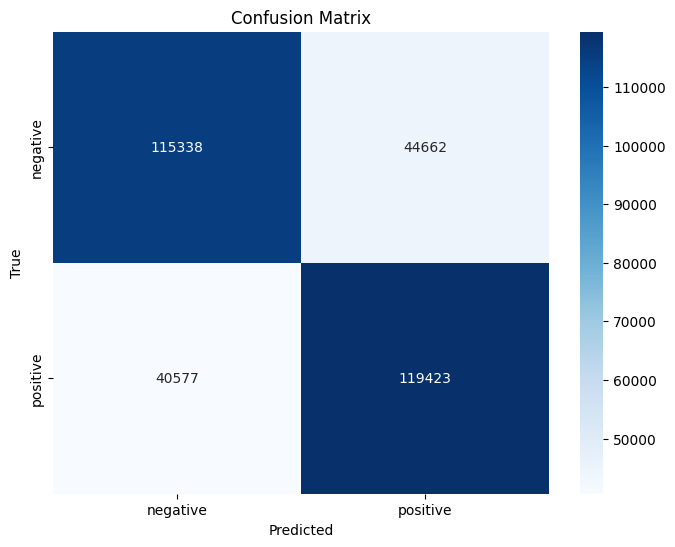


Sample Predictions:
Text: dont awnser meeeeeeeeee
True label: negative
Predicted label: negative (Confidence: 84.58%)
--------------------------------------------------------------------------------
Text: liking idea school day hopefully able work go
True label: positive
Predicted label: positive (Confidence: 60.03%)
--------------------------------------------------------------------------------
Text: hey run bike swim fast u want catch
True label: positive
Predicted label: positive (Confidence: 51.74%)
--------------------------------------------------------------------------------
Text: sister kidnap quot estrellita quot old white lion since little girl mean
True label: negative
Predicted label: positive (Confidence: 62.36%)
--------------------------------------------------------------------------------
Text: correct choice horrible think even think watching movie made kid
True label: positive
Predicted label: positive (Confidence: 50.98%)
-----------------------------------------

In [22]:
# Evaluate the model on test data
test_loss, test_accuracy = model.evaluate(X_test_vec, y_test_cat, verbose=1)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

# Get detailed metrics
from sklearn.metrics import classification_report, confusion_matrix

# Make predictions on test data
y_pred_probs = model.predict(X_test_vec, batch_size=256)
y_pred_classes = np.argmax(y_pred_probs, axis=1)
y_test_classes = np.argmax(y_test_cat, axis=1)

# Print classification report
print("\nClassification Report:")
print(classification_report(y_test_classes, y_pred_classes, target_names=le.classes_))

# Print confusion matrix
print("\nConfusion Matrix:")
conf_matrix = confusion_matrix(y_test_classes, y_pred_classes)
print(conf_matrix)

# Visualize confusion matrix
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Print some example predictions
print("\nSample Predictions:")
indices = np.random.randint(0, len(test), 5)
for i in indices:
    text = test['text'].iloc[i]
    true_label = test['label'].iloc[i]
    pred_label = le.classes_[y_pred_classes[i]]
    confidence = np.max(y_pred_probs[i]) * 100
    
    print(f"Text: {text[:100]}..." if len(text) > 100 else f"Text: {text}")
    print(f"True label: {true_label}")
    print(f"Predicted label: {pred_label} (Confidence: {confidence:.2f}%)")
    print("-" * 80)

### Model 2: scales (3,4,5)

In [15]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, Concatenate, Dense, Dropout, Embedding, Reshape, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder

# Check for GPU availability
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("GPU memory growth set to True")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)
    print(f"Using GPU: {gpus[0].name}")
else:
    print("No GPU found. Using CPU instead.")

# Set TensorFlow to use GPU if available
tf.config.set_visible_devices(gpus, 'GPU')

le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_val_encoded = le.transform(y_val)
y_test_encoded = le.transform(y_test)

y_train_cat = to_categorical(y_train_encoded)
y_val_cat = to_categorical(y_val_encoded)
y_test_cat = to_categorical(y_test_encoded)

embedding_dim = 300
max_sequence_length = 50
num_filters = 2
region_sizes = [3, 4, 5]
num_classes = len(le.classes_)

# Define the model
input_shape = (embedding_dim,)
inputs = Input(shape=input_shape)

reshaped = Reshape((1, embedding_dim))(inputs)

pooled_outputs = []

for region_size in region_sizes:
    conv = Conv1D(filters=num_filters,
                 kernel_size=1,
                 padding='valid',
                 activation='tanh')(reshaped)
    
    pooled = MaxPooling1D(pool_size=1)(conv)
    
    flat = Flatten()(pooled)
    
    pooled_outputs.append(flat)


concatenated = Concatenate()(pooled_outputs)


dropout = Dropout(0.5)(concatenated)

outputs = Dense(num_classes, activation='sigmoid')(dropout)

# Create and compile the model
model = Model(inputs=inputs, outputs=outputs)
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='binary_crossentropy',
              metrics=['accuracy'])


model.summary()

history = model.fit(
    X_train_vec, y_train_cat,
    validation_data=(X_val_vec, y_val_cat),
    epochs=10,
    batch_size=256
)

model.save('sentiment_cnn_model2_gpu.h5')

import pickle
with open('label_encoder.pkl', 'wb') as f:
    pickle.dump(le, f)

Num GPUs Available:  1
GPU memory growth set to True
Using GPU: /physical_device:GPU:0


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 300)            │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape_2 (Reshape)       │ (None, 1, 300)         │              0 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_6 (Conv1D)         │ (None, 1, 2)           │            602 │ reshape_2[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_7 (Conv1D)         │ (None, 1, 2)           │            602 │ reshape_2[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_8 (Conv1D)         │ (None, 1, 2)           │            602 │ reshape_2[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling1d_6           │ (None, 1, 2)           │              0 │ conv1d_6[0][0]         │
│ (MaxPooling1D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling1d_7           │ (None, 1, 2)           │              0 │ conv1d_7[0][0]         │
│ (MaxPooling1D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling1d_8           │ (None, 1, 2)           │              0 │ conv1d_8[0][0]         │
│ (MaxPooling1D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_6 (Flatten)       │ (None, 2)              │              0 │ max_pooling1d_6[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_7 (Flatten)       │ (None, 2)              │              0 │ max_pooling1d_7[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_8 (Flatten)       │ (None, 2)              │              0 │ max_pooling1d_8[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_2             │ (None, 6)              │              0 │ flatten_6[0][0],       │
│ (Concatenate)             │                        │                │ flatten_7[0][0],       │
│                           │                        │                │ flatten_8[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_2 (Dropout)       │ (None, 6)              │              0 │ concatenate_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 2)              │             14 │ dropout_2[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 1,820 (7.11 KB)

 Trainable params: 1,820 (7.11 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
4500/4500 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - accuracy: 0.6296 - loss: 0.6621 - val_accuracy: 0.7093 - val_loss: 0.5867
Epoch 2/10
4500/4500 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.7098 - loss: 0.5852 - val_accuracy: 0.7225 - val_loss: 0.5548
Epoch 3/10
4500/4500 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.7197 - loss: 0.5658 - val_accuracy: 0.7264 - val_loss: 0.5459
Epoch 4/10
4500/4500 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.7240 - loss: 0.5606 - val_accuracy: 0.7285 - val_loss: 0.5428
Epoch 5/10
4500/4500 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.7261 - loss: 0.5575 - val_accuracy: 0.7287 - val_loss: 0.5410
Epoch 6/10
4500/4500 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.7268 - loss: 0.5563 - val_accuracy: 0.7302 - val_loss: 0.5398
Epoch 7/10
4500/4500 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.7272 - loss: 0.5562 - val_accuracy: 0.7305 - val_loss: 0.5389
Epoch 8/10
4500/4500 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.7278 - loss: 0.5548 -

10000/10000 ━━━━━━━━━━━━━━━━━━━━ 13s 1ms/step - accuracy: 0.7328 - loss: 0.5382
Test Loss: 0.5385
Test Accuracy: 0.7334
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step

Classification Report:
              precision    recall  f1-score   support

    negative       0.74      0.72      0.73    160000
    positive       0.73      0.75      0.74    160000

    accuracy                           0.73    320000
   macro avg       0.73      0.73      0.73    320000
weighted avg       0.73      0.73      0.73    320000


Confusion Matrix:
[[115080  44920]
 [ 40383 119617]]


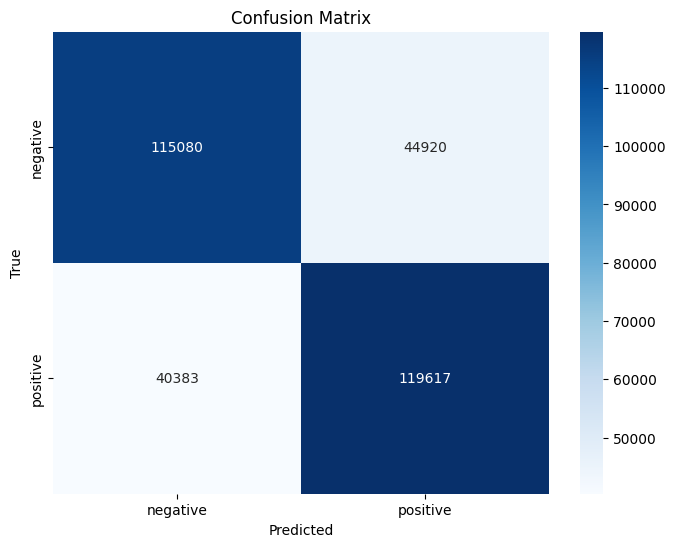


Sample Predictions:
Text: love new tagline also sell twitter
True label: positive
Predicted label: positive (Confidence: 84.82%)
--------------------------------------------------------------------------------
Text: need giant polar bear keep safe always feel safe bobo side
True label: positive
Predicted label: positive (Confidence: 58.33%)
--------------------------------------------------------------------------------
Text: see awake morning needed yesterday statistic homework
True label: negative
Predicted label: negative (Confidence: 60.61%)
--------------------------------------------------------------------------------
Text: guess girl gone
True label: negative
Predicted label: negative (Confidence: 72.94%)
--------------------------------------------------------------------------------
Text: call selena
True label: positive
Predicted label: positive (Confidence: 55.56%)
--------------------------------------------------------------------------------


In [16]:
# Evaluate the model on test data
test_loss, test_accuracy = model.evaluate(X_test_vec, y_test_cat, verbose=1)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

# Get detailed metrics
from sklearn.metrics import classification_report, confusion_matrix

# Make predictions on test data
y_pred_probs = model.predict(X_test_vec, batch_size=256)
y_pred_classes = np.argmax(y_pred_probs, axis=1)
y_test_classes = np.argmax(y_test_cat, axis=1)

# Print classification report
print("\nClassification Report:")
print(classification_report(y_test_classes, y_pred_classes, target_names=le.classes_))

# Print confusion matrix
print("\nConfusion Matrix:")
conf_matrix = confusion_matrix(y_test_classes, y_pred_classes)
print(conf_matrix)

# Visualize confusion matrix
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Print some example predictions
print("\nSample Predictions:")
indices = np.random.randint(0, len(test), 5)
for i in indices:
    text = test['text'].iloc[i]
    true_label = test['label'].iloc[i]
    pred_label = le.classes_[y_pred_classes[i]]
    confidence = np.max(y_pred_probs[i]) * 100
    
    print(f"Text: {text[:100]}..." if len(text) > 100 else f"Text: {text}")
    print(f"True label: {true_label}")
    print(f"Predicted label: {pred_label} (Confidence: {confidence:.2f}%)")
    print("-" * 80)

### Model 3: scales (4,5,6)

In [23]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, Concatenate, Dense, Dropout, Embedding, Reshape, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder

# Check for GPU availability
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("GPU memory growth set to True")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)
    print(f"Using GPU: {gpus[0].name}")
else:
    print("No GPU found. Using CPU instead.")

# Set TensorFlow to use GPU if available
tf.config.set_visible_devices(gpus, 'GPU')

le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_val_encoded = le.transform(y_val)
y_test_encoded = le.transform(y_test)

y_train_cat = to_categorical(y_train_encoded)
y_val_cat = to_categorical(y_val_encoded)
y_test_cat = to_categorical(y_test_encoded)

embedding_dim = 300
max_sequence_length = 50
num_filters = 2
region_sizes = [4, 5, 6]
num_classes = len(le.classes_)

# Define the model
input_shape = (embedding_dim,)
inputs = Input(shape=input_shape)

reshaped = Reshape((1, embedding_dim))(inputs)

pooled_outputs = []

for region_size in region_sizes:
    conv = Conv1D(filters=num_filters,
                 kernel_size=1,
                 padding='valid',
                 activation='tanh')(reshaped)
    
    pooled = MaxPooling1D(pool_size=1)(conv)
    
    flat = Flatten()(pooled)
    
    pooled_outputs.append(flat)


concatenated = Concatenate()(pooled_outputs)


dropout = Dropout(0.5)(concatenated)

outputs = Dense(num_classes, activation='sigmoid')(dropout)

# Create and compile the model
model = Model(inputs=inputs, outputs=outputs)
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='binary_crossentropy',
              metrics=['accuracy'])


model.summary()

history = model.fit(
    X_train_vec, y_train_cat,
    validation_data=(X_val_vec, y_val_cat),
    epochs=10,
    batch_size=256
)

model.save('sentiment_cnn_model3_gpu.h5')

import pickle
with open('label_encoder.pkl', 'wb') as f:
    pickle.dump(le, f)

Num GPUs Available:  1
GPU memory growth set to True
Using GPU: /physical_device:GPU:0


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5             │ (None, 300)            │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape_5 (Reshape)       │ (None, 1, 300)         │              0 │ input_layer_5[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_15 (Conv1D)        │ (None, 1, 2)           │            602 │ reshape_5[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_16 (Conv1D)        │ (None, 1, 2)           │            602 │ reshape_5[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_17 (Conv1D)        │ (None, 1, 2)           │            602 │ reshape_5[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling1d_15          │ (None, 1, 2)           │              0 │ conv1d_15[0][0]        │
│ (MaxPooling1D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling1d_16          │ (None, 1, 2)           │              0 │ conv1d_16[0][0]        │
│ (MaxPooling1D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling1d_17          │ (None, 1, 2)           │              0 │ conv1d_17[0][0]        │
│ (MaxPooling1D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_15 (Flatten)      │ (None, 2)              │              0 │ max_pooling1d_15[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_16 (Flatten)      │ (None, 2)              │              0 │ max_pooling1d_16[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_17 (Flatten)      │ (None, 2)              │              0 │ max_pooling1d_17[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_5             │ (None, 6)              │              0 │ flatten_15[0][0],      │
│ (Concatenate)             │                        │                │ flatten_16[0][0],      │
│                           │                        │                │ flatten_17[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_5 (Dropout)       │ (None, 6)              │              0 │ concatenate_5[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_5 (Dense)           │ (None, 2)              │             14 │ dropout_5[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 1,820 (7.11 KB)

 Trainable params: 1,820 (7.11 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
4500/4500 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - accuracy: 0.6293 - loss: 0.6630 - val_accuracy: 0.7116 - val_loss: 0.5854
Epoch 2/10
4500/4500 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.7114 - loss: 0.5846 - val_accuracy: 0.7233 - val_loss: 0.5538
Epoch 3/10
4500/4500 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.7210 - loss: 0.5659 - val_accuracy: 0.7267 - val_loss: 0.5454
Epoch 4/10
4500/4500 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.7244 - loss: 0.5604 - val_accuracy: 0.7288 - val_loss: 0.5422
Epoch 5/10
4500/4500 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.7265 - loss: 0.5571 - val_accuracy: 0.7297 - val_loss: 0.5405
Epoch 6/10
4500/4500 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.7278 - loss: 0.5567 - val_accuracy: 0.7304 - val_loss: 0.5395
Epoch 7/10
4500/4500 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.7280 - loss: 0.5559 - val_accuracy: 0.7308 - val_loss: 0.5387
Epoch 8/10
4500/4500 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.7286 - loss: 0.5549 -

10000/10000 ━━━━━━━━━━━━━━━━━━━━ 12s 1ms/step - accuracy: 0.7326 - loss: 0.5381
Test Loss: 0.5384
Test Accuracy: 0.7335
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step

Classification Report:
              precision    recall  f1-score   support

    negative       0.74      0.72      0.73    160000
    positive       0.73      0.75      0.74    160000

    accuracy                           0.73    320000
   macro avg       0.73      0.73      0.73    320000
weighted avg       0.73      0.73      0.73    320000


Confusion Matrix:
[[115112  44888]
 [ 40389 119611]]


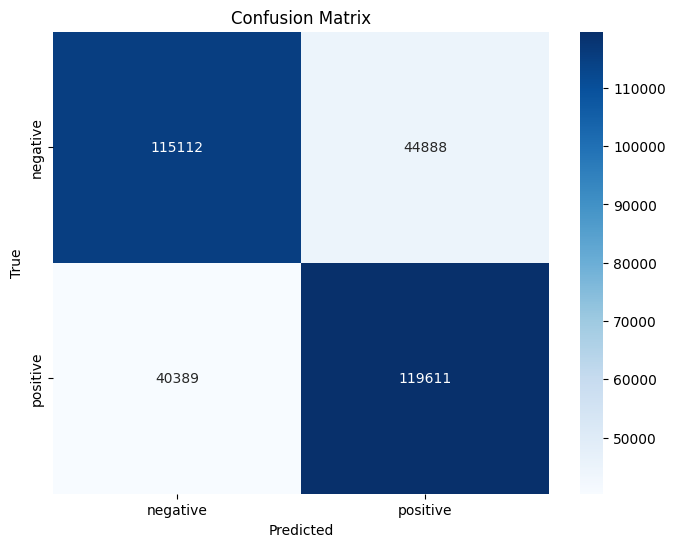


Sample Predictions:
Text: g mornin hope yall splendorific day
True label: positive
Predicted label: positive (Confidence: 73.20%)
--------------------------------------------------------------------------------
Text: hello wanted encourage hope wonderful day
True label: positive
Predicted label: positive (Confidence: 80.47%)
--------------------------------------------------------------------------------
Text: thank must follow guy follower nr far
True label: positive
Predicted label: positive (Confidence: 77.16%)
--------------------------------------------------------------------------------
Text: dire need twitsperation feel free hate using word
True label: positive
Predicted label: negative (Confidence: 88.15%)
--------------------------------------------------------------------------------
Text: oh sound great bet look forward
True label: positive
Predicted label: positive (Confidence: 89.37%)
--------------------------------------------------------------------------------


In [24]:
# Evaluate the model on test data
test_loss, test_accuracy = model.evaluate(X_test_vec, y_test_cat, verbose=1)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

# Get detailed metrics
from sklearn.metrics import classification_report, confusion_matrix

# Make predictions on test data
y_pred_probs = model.predict(X_test_vec, batch_size=256)
y_pred_classes = np.argmax(y_pred_probs, axis=1)
y_test_classes = np.argmax(y_test_cat, axis=1)

# Print classification report
print("\nClassification Report:")
print(classification_report(y_test_classes, y_pred_classes, target_names=le.classes_))

# Print confusion matrix
print("\nConfusion Matrix:")
conf_matrix = confusion_matrix(y_test_classes, y_pred_classes)
print(conf_matrix)

# Visualize confusion matrix
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Print some example predictions
print("\nSample Predictions:")
indices = np.random.randint(0, len(test), 5)
for i in indices:
    text = test['text'].iloc[i]
    true_label = test['label'].iloc[i]
    pred_label = le.classes_[y_pred_classes[i]]
    confidence = np.max(y_pred_probs[i]) * 100
    
    print(f"Text: {text[:100]}..." if len(text) > 100 else f"Text: {text}")
    print(f"True label: {true_label}")
    print(f"Predicted label: {pred_label} (Confidence: {confidence:.2f}%)")
    print("-" * 80)

## The best model

In [22]:
def predict_sentiment(sentence, model, word2vec_model, le):
    # Convert sentence to vector using the same process as training data
    sentence_vec = np.array([sentence_to_vec(sentence, word2vec_model)])
    
    # Make prediction
    prediction = model.predict(sentence_vec)[0]
    predicted_class = np.argmax(prediction)
    predicted_label = le.inverse_transform([predicted_class])[0]
    confidence = np.max(prediction) * 100
    
    return {
        'sentence': sentence,
        'predicted_label': predicted_label,
        'confidence': confidence,
        'probabilities': {label: float(prediction[i]) for i, label in enumerate(le.classes_)}
    }

# Example usage
test_sentences = [
    "I love this movie! It's absolutely amazing.",
    "This film was just okay, nothing special.",
    "Terrible movie, complete waste of time.",
    "The acting was good but the plot was confusing.",
    "I'm looking forward to watching the sequel."
]

print("Sentiment Predictions:")
print("-" * 80)
for sentence in test_sentences:
    result = predict_sentiment(sentence, model, model_emb, le)
    print(f"Sentence: {result['sentence']}")
    print(f"Predicted sentiment: {result['predicted_label']}")
    print(f"Confidence: {result['confidence']:.2f}%")
    print(f"Class probabilities: {result['probabilities']}")
    print("-" * 80)

# Interactive testing
while True:
    user_input = input("\nEnter a sentence to analyze (or 'quit' to exit): ")
    if user_input.lower() == 'quit':
        break
    
    result = predict_sentiment(user_input, model, model_emb, le)
    print(f"Predicted sentiment: {result['predicted_label']}")
    print(f"Confidence: {result['confidence']:.2f}%")

Sentiment Predictions:
--------------------------------------------------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 336ms/step
Sentence: I love this movie! It's absolutely amazing.
Predicted sentiment: positive
Confidence: 82.09%
Class probabilities: {'negative': 0.17913556098937988, 'positive': 0.8208644390106201}
--------------------------------------------------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Sentence: This film was just okay, nothing special.
Predicted sentiment: negative
Confidence: 67.85%
Class probabilities: {'negative': 0.678483247756958, 'positive': 0.3215167820453644}
--------------------------------------------------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Sentence: Terrible movie, complete waste of time.
Predicted sentiment: negative
Confidence: 75.93%
Class probabilities: {'negative': 0.7592683434486389, 'positive': 0.2407316267490387}
----------------------------------------------------------


Enter a sentence to analyze (or 'quit' to exit):  quit
